In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from project_resources.import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import fp_from_smiles, mol_predict_and_std, tanimoto, create_scatter_plot

importing Jupyter notebook from C:\Users\Lukas\Documents\datacytochromy\project_resources\cytochrome_P450.ipynb


In [2]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
isozymes = ["3A4", "RLM", "HLC"]
data_splits = ["train", "test"]
splitters = ["rand", "scaff", "time"]
rel_paths = {
    "3A4_source": r"project_resources/ChEMBL_3A4.csv",
    "3A4_sep": ";",
    "3A4": r"project_resources/3A4.csv",
    "3A4_train_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_train.csv",
    "3A4_test_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_test.csv",
    "3A4_train_rand": r"project_resources/base_splits/random/3A4_train.csv",
    "3A4_test_rand": r"project_resources/base_splits/random/3A4_test.csv",
    "3A4_train_time": r"project_resources/base_splits/time_split/3A4_train.csv",
    "3A4_test_time": r"project_resources/base_splits/time_split/3A4_test.csv",

    "RLM_source": r"project_resources/AID_1508591_datatable_all.csv",
    "RLM_sep": ",",
    "RLM": r"project_resources/RLM.csv",
    "RLM_train_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_train.csv",
    "RLM_test_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_test.csv",
    "RLM_train_rand": r"project_resources/base_splits/random/RLM_train.csv",
    "RLM_test_rand": r"project_resources/base_splits/random/RLM_test.csv",
    "RLM_train_time": r"project_resources/base_splits/time_split/RLM_train.csv",
    "RLM_test_time": r"project_resources/base_splits/time_split/RLM_test.csv",

    "HLC_source": r"project_resources/AID_1508603_datatable_all.csv",
    "HLC_sep": ",",
    "HLC": r"project_resources/HLC.csv",
    "HLC_train_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_train.csv",
    "HLC_test_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_test.csv",
    "HLC_train_rand": r"project_resources/base_splits/random/HLC_train.csv",
    "HLC_test_rand": r"project_resources/base_splits/random/HLC_test.csv",
    "HLC_train_time": r"project_resources/base_splits/time_split/HLC_train.csv",
    "HLC_test_time": r"project_resources/base_splits/time_split/HLC_test.csv"
}

smiles = {}
halflives = {}
fingerprints = {}
tanimoto_sims = {}
y_test_avg_predictions = {}
stds = {}
rmsds = {}
best_models = {}

In [3]:
# load train-test
for splitter in splitters:
    print(splitter)
    smiles[splitter] = {}
    halflives[splitter] = {}
    for isozyme in isozymes:
        smiles[splitter][isozyme] = {}
        halflives[splitter][isozyme] = {}

        for data_split in data_splits:
            # load smiles
            split_df = pd.read_csv(rel_paths[f"{isozyme}_{data_split}_{splitter}"])
            split_smi = np.array(split_df["smiles"])
            smiles[splitter][isozyme][data_split] = split_smi

            # load half-life
            split_df = pd.read_csv(rel_paths[f"{isozyme}_{data_split}_{splitter}"])
            split_halflife = np.array(split_df["half-life"])
            halflives[splitter][isozyme][data_split] = split_halflife

        print(f"""{isozyme}
    x_train: {smiles[splitter][isozyme]["train"][0]}
    x_test: {smiles[splitter][isozyme]["test"][0]}
    y_train: {halflives[splitter][isozyme]["train"][:3]}
    y_test: {halflives[splitter][isozyme]["test"][:3]}
    """)

rand
3A4
    x_train: CC(C)(O)c1cc(F)c2c(c1)C(=O)N(Cc1ccc(Cl)cn1)[C@@]2(OCC1(O)CC1)c1ccc(Cl)cc1
    x_test: Cc1ncsc1-c1ccc([C@H](CC(=O)NCCCCCCNC(=O)COc2c(-c3csc(N4CCOCC4)n3)ccc(F)c2F)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)C2(F)CC2)C(C)(C)C)cc1
    y_train: [1.         0.00277938 0.08282384]
    y_test: [0.06226242 0.05502507 0.00183385]
    
RLM
    x_train: CN1C(=O)c2ccccc2[S@+]([O-])c2ccc(C(=O)NCc3ccc(Br)cc3)cc21
    x_test: CC(=O)c1c(C)[nH]c(C(=O)Nc2cccc([S+](=O)([O-])Nc3cccc(C#N)c3)c2)c1C
    y_train: [0.41810643 0.66897028 0.93642018]
    y_test: [0.83275743 0.15756738 0.1935038 ]
    
HLC
    x_train: N#Cc1ccc(CN2CCC(N3CCNC3=O)CC2)cc1
    x_test: c1ccc(Nc2ncc(-c3cncnc3)c3c2OCC3)cc1
    y_train: [0.76156584 0.11921708 0.38434164]
    y_test: [1.         0.92793594 0.4430605 ]
    
scaff
3A4
    x_train: COc1cccc([C@@H](CO)NC(=O)[C@@H](C)N2Cc3ccc(-c4nc(NC5CCOCC5)ncc4Cl)cc3C2=O)c1
    x_test: O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCNC(=O)c4ccc5c(c4)nc(Nc4cccc(Cl)c4)c4ccncc45)c3C2=O)C(=O

In [4]:
# convert smiles from every isozyme and split to Morgan fingerprint as numpy array
for splitter in splitters:
    fingerprints[splitter] = {}
    for isozyme in isozymes:
        fingerprints[splitter][isozyme] = {}
        for data_split in data_splits:
            fps = fp_from_smiles(smiles[splitter][isozyme][data_split])
            fingerprints[splitter][isozyme][data_split] = np.array(fps)
            print(splitter, isozyme, data_split)
            print(fps[0])
        print("\n")

rand 3A4 train
[1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 1 0 0 0 1 1 1 0]
rand 3A4 test
[1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1
 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0
 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1
 1 1 0 0 0 1 0 1 1 1 1 1 1]


rand RLM train
[0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0
 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 1]
rand RLM test
[0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0
 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 

In [5]:
for splitter in splitters:
    y_test_avg_predictions[splitter] = {}
    stds[splitter] = {}
    rmsds[splitter] = {}
    for isozyme in isozymes:
        x_train = fingerprints[splitter][isozyme]["train"]
        y_train = halflives[splitter][isozyme]["train"]
        x_test = fingerprints[splitter][isozyme]["test"]
        y_test = halflives[splitter][isozyme]["test"]
        print(splitter, isozyme)
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        y_test_avg_predict, std, rmsd = mol_predict_and_std(models, x_train, x_test, y_train, y_test)
        y_test_avg_predictions[splitter][isozyme] = y_test_avg_predict
        stds[splitter][isozyme] = std
        rmsds[splitter][isozyme] = rmsd
        print(f"     root-mean-square deviations: {rmsds[splitter][isozyme]}\n")

rand 3A4
(56, 124) (56,) (14, 124) (14,)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0)
     best linear hyperparams: ElasticNet(alpha=0.01)
     best linear hyperparams: ElasticNet(alpha=0.01)
     best KRR hyperparams: KernelRidge(alpha=0.26366508987303583, gamma=0.183298071083243, kernel='rbf')
     best KRR hyperparams: KernelRidge(alpha=0.00379269019073225, gamma=1.0, kernel='laplacian')
     best KRR hyperparams: KernelRidge(alpha=5.455594781168514, gamma=0.183298071083243, kernel='rbf')
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, n_estimators=10)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, max_depth=1, n_estimators=10)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, max_depth=2, n_estimators=10)
     best RF hyperparams: RandomForestRegressor(max_depth=2, max_features='log2', n_estimators=200)
     best RF hyperparams: RandomForestRegressor(max_depth=5, max_features='log2', n_estima

In [6]:
for splitter in splitters:
    print(splitter)
    best_models[splitter] = {}
    for isozyme in isozymes:
        isozyme_rmsds = list(rmsds[splitter][isozyme].values())
        lowest_rmsd = min(isozyme_rmsds)
        best_model_for_isozyme = list(rmsds[splitter][isozyme].keys())[list(rmsds[splitter][isozyme].values()).index(lowest_rmsd)]
        best_models[splitter][isozyme] = best_model_for_isozyme
        print(f"best model for {isozyme}: {best_model_for_isozyme} with rmsd {lowest_rmsd}")

rand
best model for 3A4: ANN with rmsd 0.1287016629903889
best model for RLM: KRR with rmsd 0.22677276535965257
best model for HLC: ANN with rmsd 0.24236029088610603
scaff
best model for 3A4: RF with rmsd 0.14266310239342733
best model for RLM: RF with rmsd 0.40262103573145636
best model for HLC: KRR with rmsd 0.5924348263032708
time
best model for 3A4: linear with rmsd 0.3641088003135686
best model for RLM: RF with rmsd 0.2534193610990875
best model for HLC: KRR with rmsd 0.3101477816807474


In [7]:
for splitter in splitters:
    print(splitter)
    tanimoto_sims[splitter] = {}
    for isozyme in isozymes:
        tanimoto_similarities = tanimoto(fingerprints[splitter][isozyme]["test"], fingerprints[splitter][isozyme]["train"])
        tanimoto_sims[splitter][isozyme] = tanimoto_similarities
        median = round(np.median(tanimoto_similarities), 3)
        mean = round(np.mean(tanimoto_similarities), 3)
        print(f"length: {len(tanimoto_similarities)}, median: {median}, arithmetic mean: {mean}, ",
              tanimoto_sims[splitter][isozyme][:10])

rand
length: 14, median: 0.832, arithmetic mean: 0.718,  [0.81, 0.406, 0.569, 0.914, 0.568, 0.883, 0.857, 0.915, 0.919, 1.0]
length: 356, median: 0.708, arithmetic mean: 0.678,  [0.889, 0.583, 0.952, 0.771, 0.878, 0.474, 0.854, 0.804, 0.889, 0.904]
length: 38, median: 0.795, arithmetic mean: 0.745,  [0.833, 0.83, 0.463, 0.757, 0.806, 0.531, 0.725, 0.867, 0.742, 0.739]
scaff
length: 14, median: 0.621, arithmetic mean: 0.613,  [0.649, 0.62, 0.509, 0.81, 0.5, 0.828, 0.833, 0.368, 0.5, 0.623]
length: 356, median: 0.552, arithmetic mean: 0.602,  [0.466, 0.474, 0.536, 0.424, 0.941, 0.72, 0.366, 0.674, 0.471, 0.812]
length: 38, median: 0.591, arithmetic mean: 0.607,  [0.686, 0.653, 0.5, 0.531, 0.561, 0.586, 0.444, 0.422, 0.533, 0.511]
time
length: 14, median: 0.865, arithmetic mean: 0.871,  [0.97, 0.8, 0.927, 0.833, 0.887, 0.843, 0.833, 0.898, 0.849, 0.886]
length: 356, median: 0.532, arithmetic mean: 0.618,  [0.898, 0.745, 0.932, 0.889, 0.804, 0.818, 0.86, 0.463, 0.87, 0.744]
length: 38, med

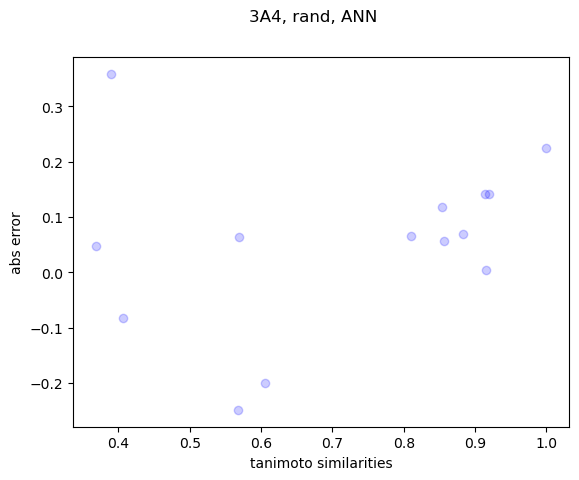

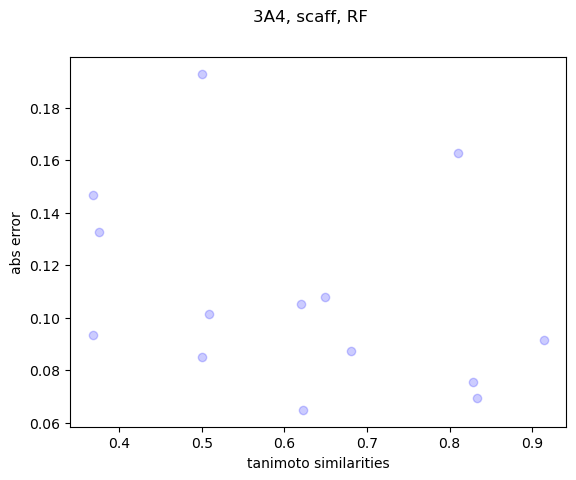

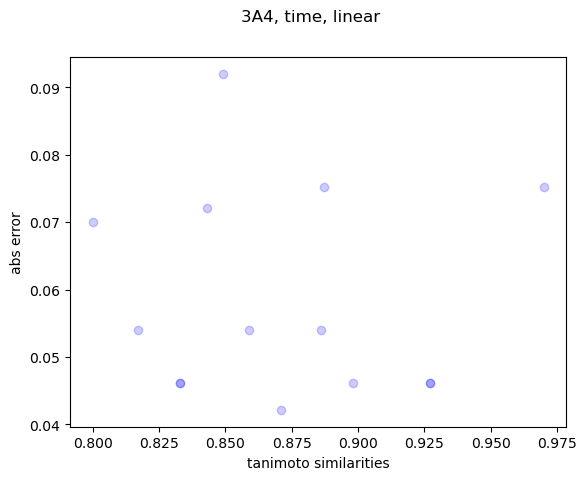

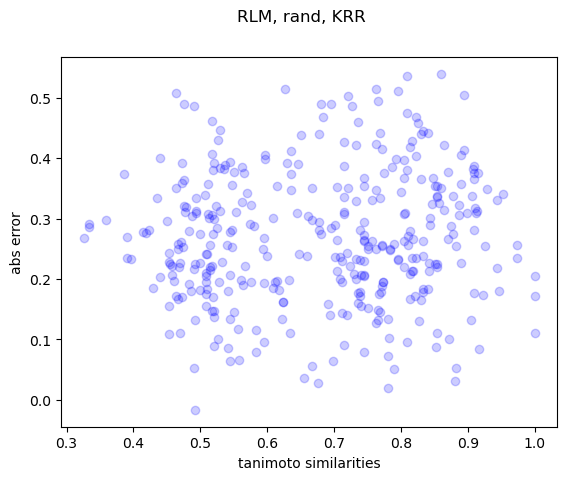

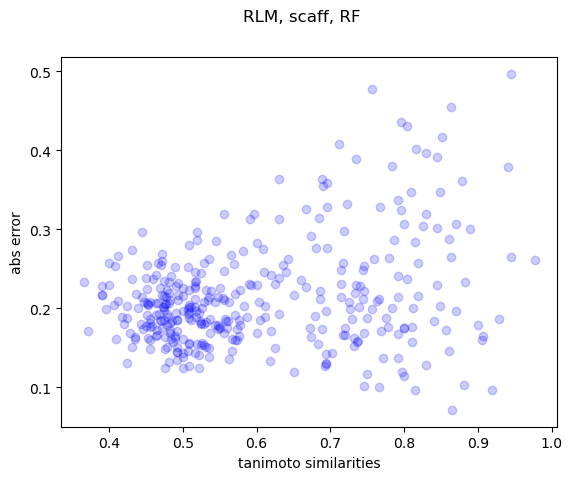

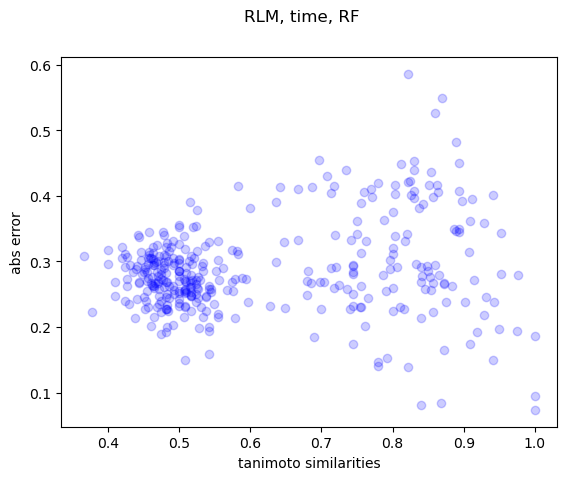

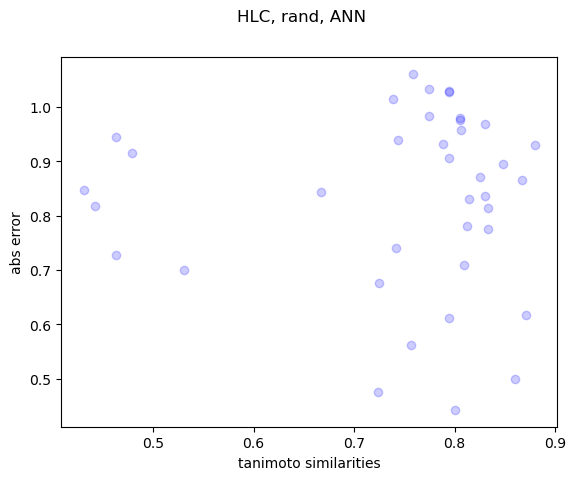

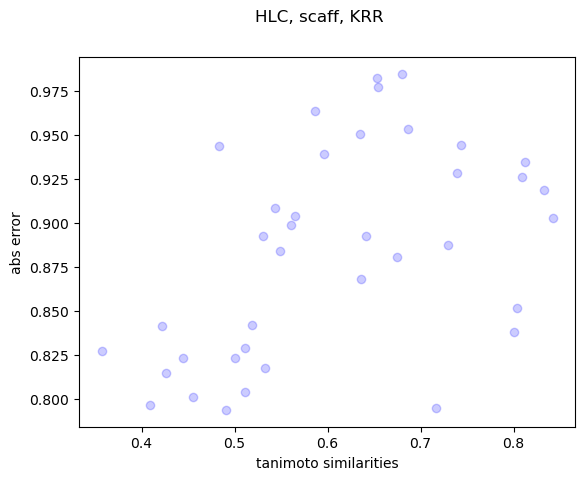

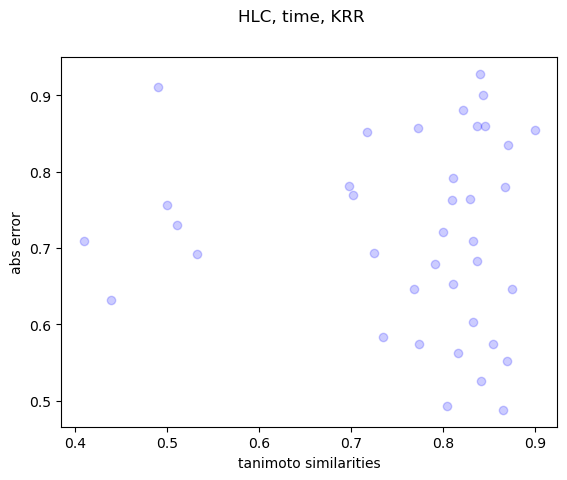

In [8]:
for isozyme in isozymes:
    for splitter in splitters:
        model = best_models[splitter][isozyme]
        create_scatter_plot(tanimoto_sims[splitter][isozyme], y_test_avg_predictions[splitter][isozyme][model],
                            f"{isozyme}, {splitter}, {model}", "tanimoto similarities", "abs error")

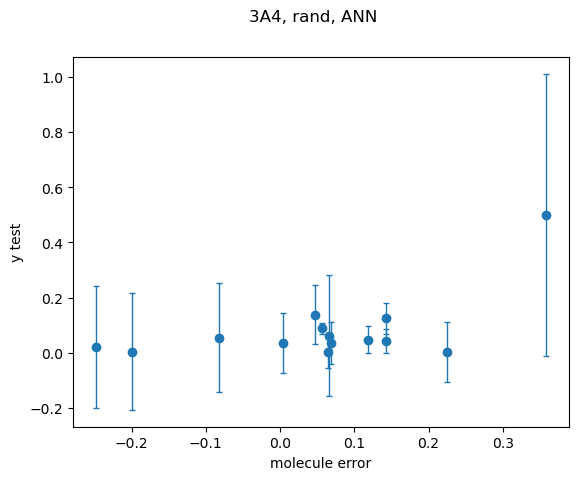

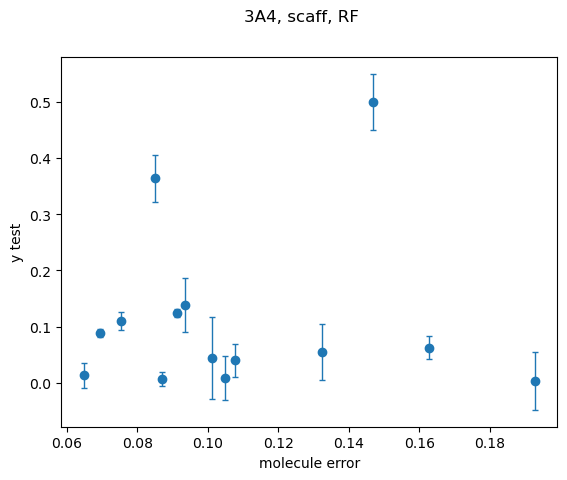

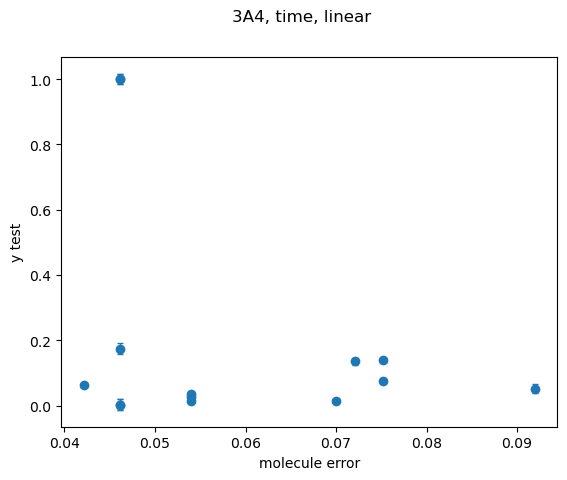

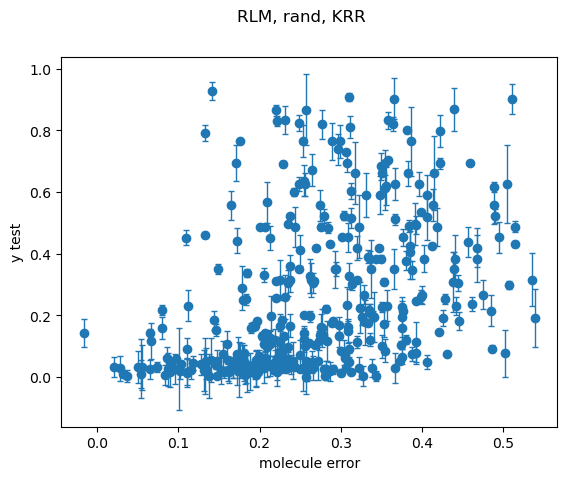

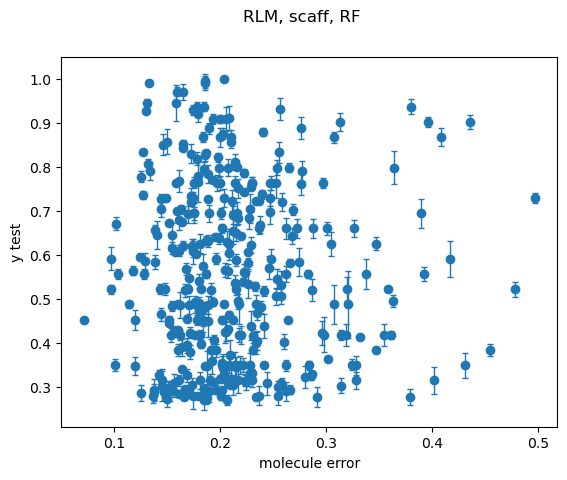

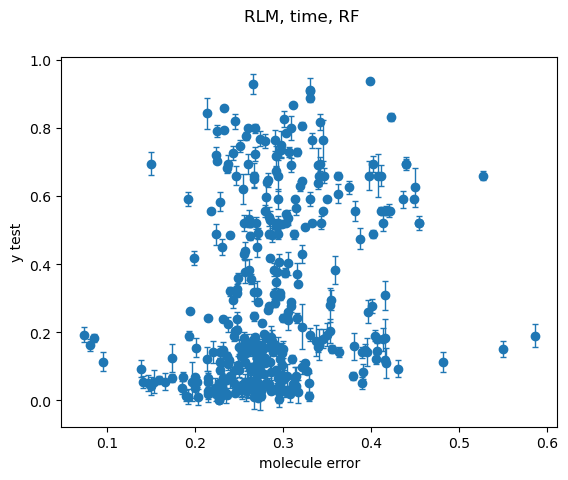

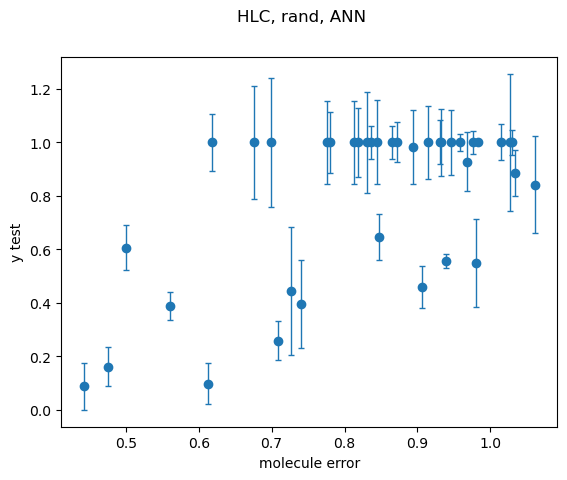

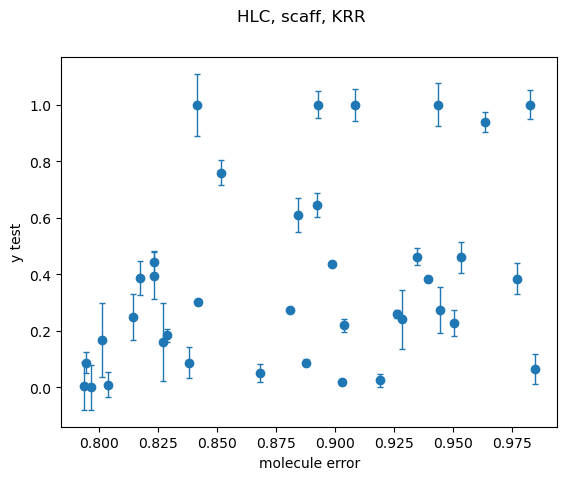

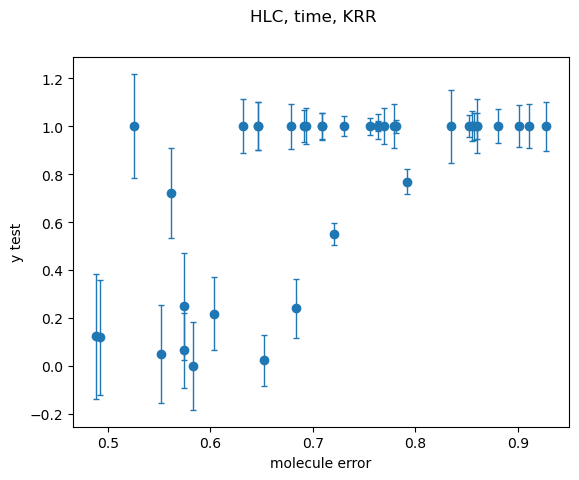

In [9]:
for isozyme in isozymes:
    for splitter in splitters:
        model = best_models[splitter][isozyme]
        plt.clf()
        plt.errorbar(y_test_avg_predictions[splitter][isozyme][model], halflives[splitter][isozyme]["test"],
                     yerr=stds[splitter][isozyme][model], linewidth=1, capsize=2, fmt='o')
        plt.xlabel('molecule error')
        plt.ylabel('y test')
        plt.suptitle(f"{isozyme}, {splitter}, {model}")
        plt.show()

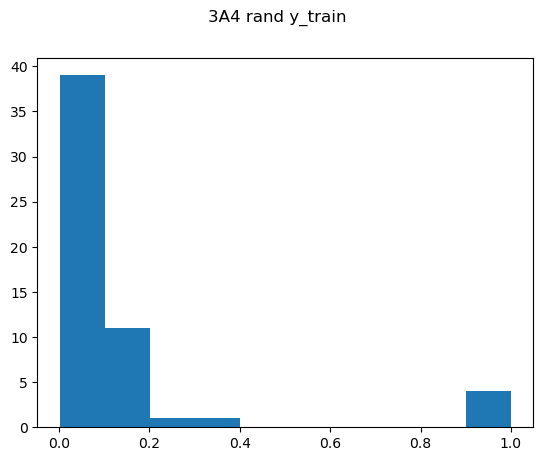

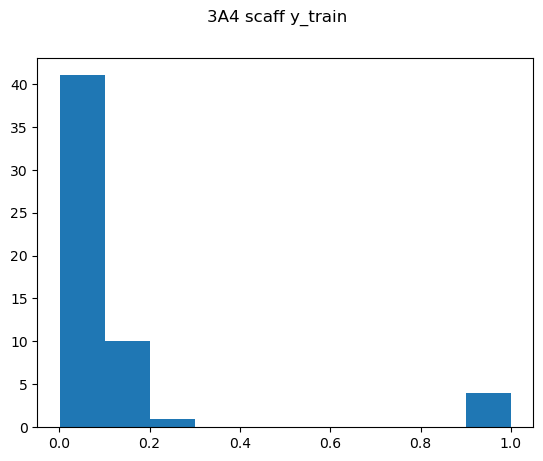

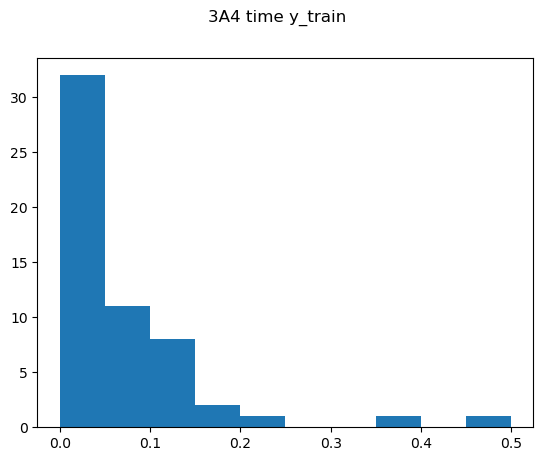

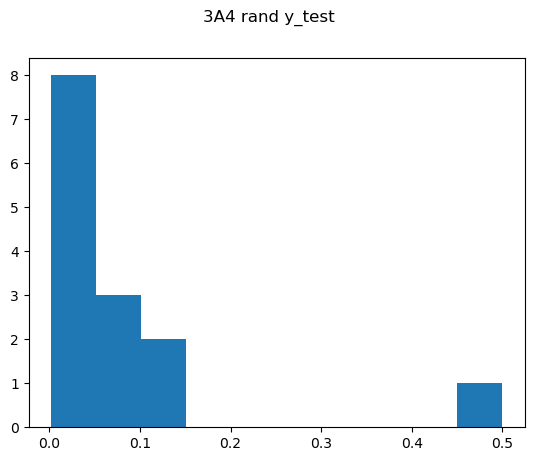

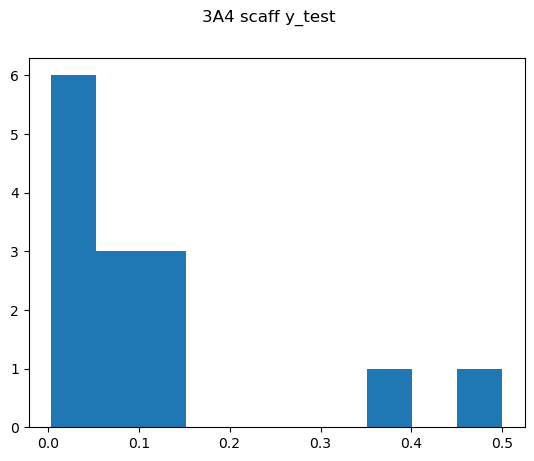

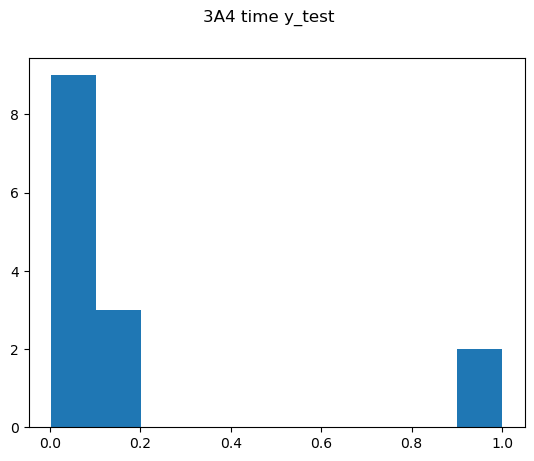

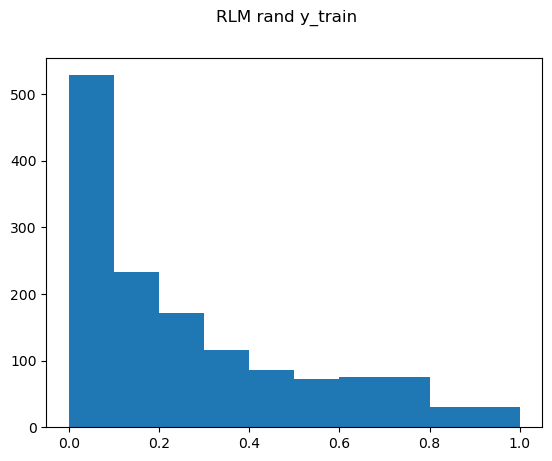

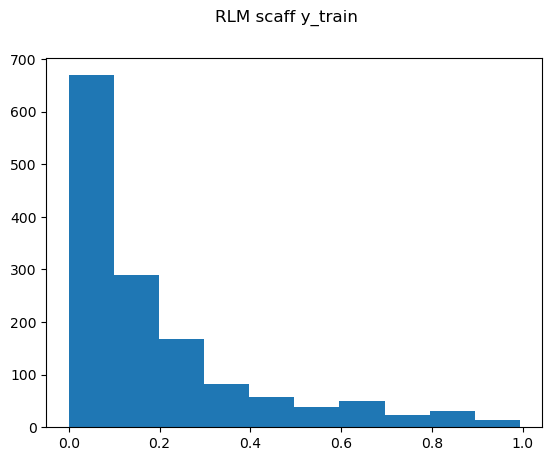

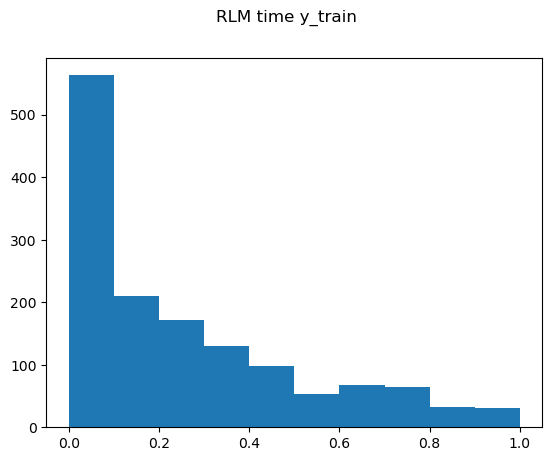

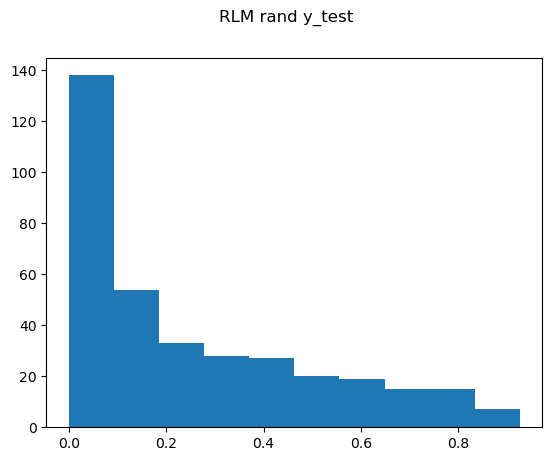

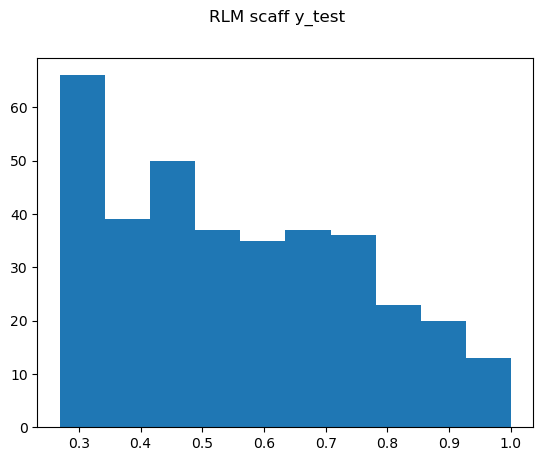

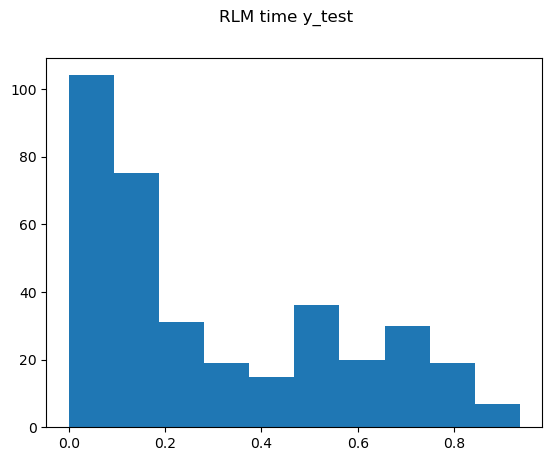

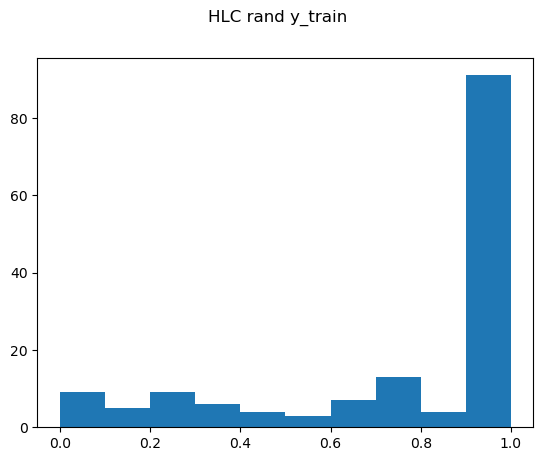

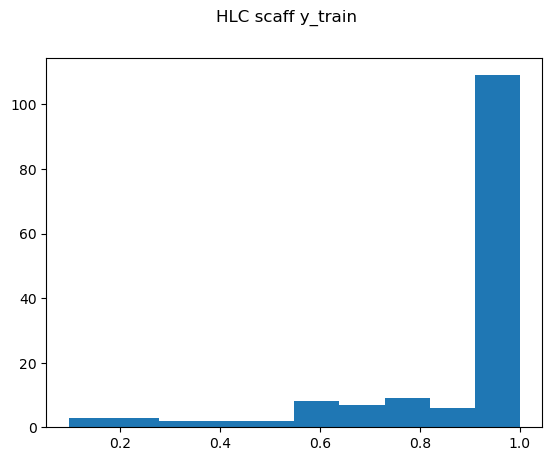

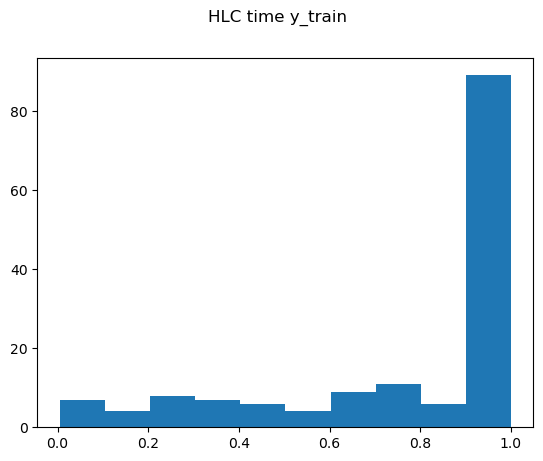

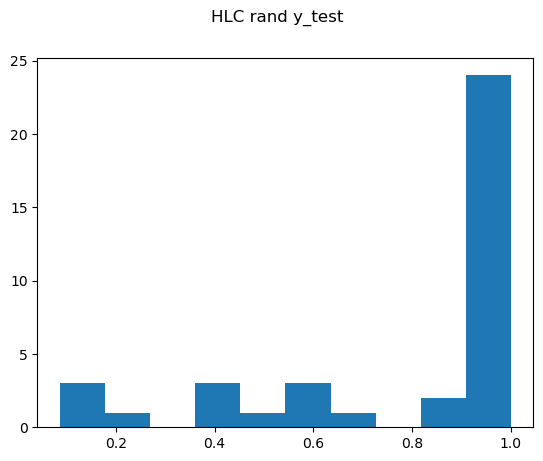

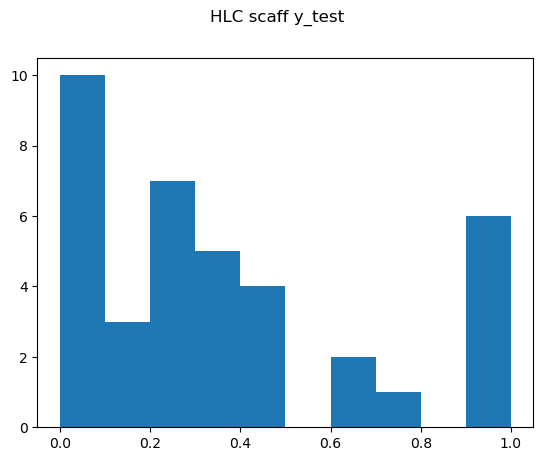

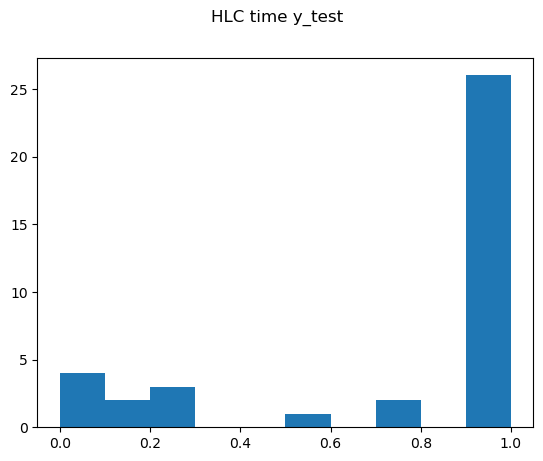

In [12]:
for isozyme in isozymes:
    for split in data_splits:
        for splitter in splitters:
            y_split = halflives[splitter][isozyme][split]
            plt.hist(y_split)
            plt.suptitle(f"{isozyme} {splitter} y_{split}")
            plt.show()